<a href="https://colab.research.google.com/github/navyakarna/PYTORCH_CV/blob/main/VGG16_IMAGE_AUGMENTATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TRANSFER LEARNING AND IMAGE AUGMENTATION


TRANSFER LEARNING GENRRALLY MEANS , LEARNING FROM A PRE TRAINED MODEL

Feature Extraction and fine tuning:
XRAY MODEL --------------TRANSFER LEARNING--------> MRI MODEL

Leveraging pre-trained models on one task to adapt to new but related tasks.

- FEATURE EXTRACTION
- FINE TUNING


TL -: FEATURE EXTRACTION
-:REMOVE AND REPLACE THE FINAL CLASSIFICATION LAYER.
-: REDUCES THE OVERALL TRAINIG TIME AND IMPROVES PERFROMANCE.
-:Pre-compute and save outputs of the frozen layers to avoid re-computation.

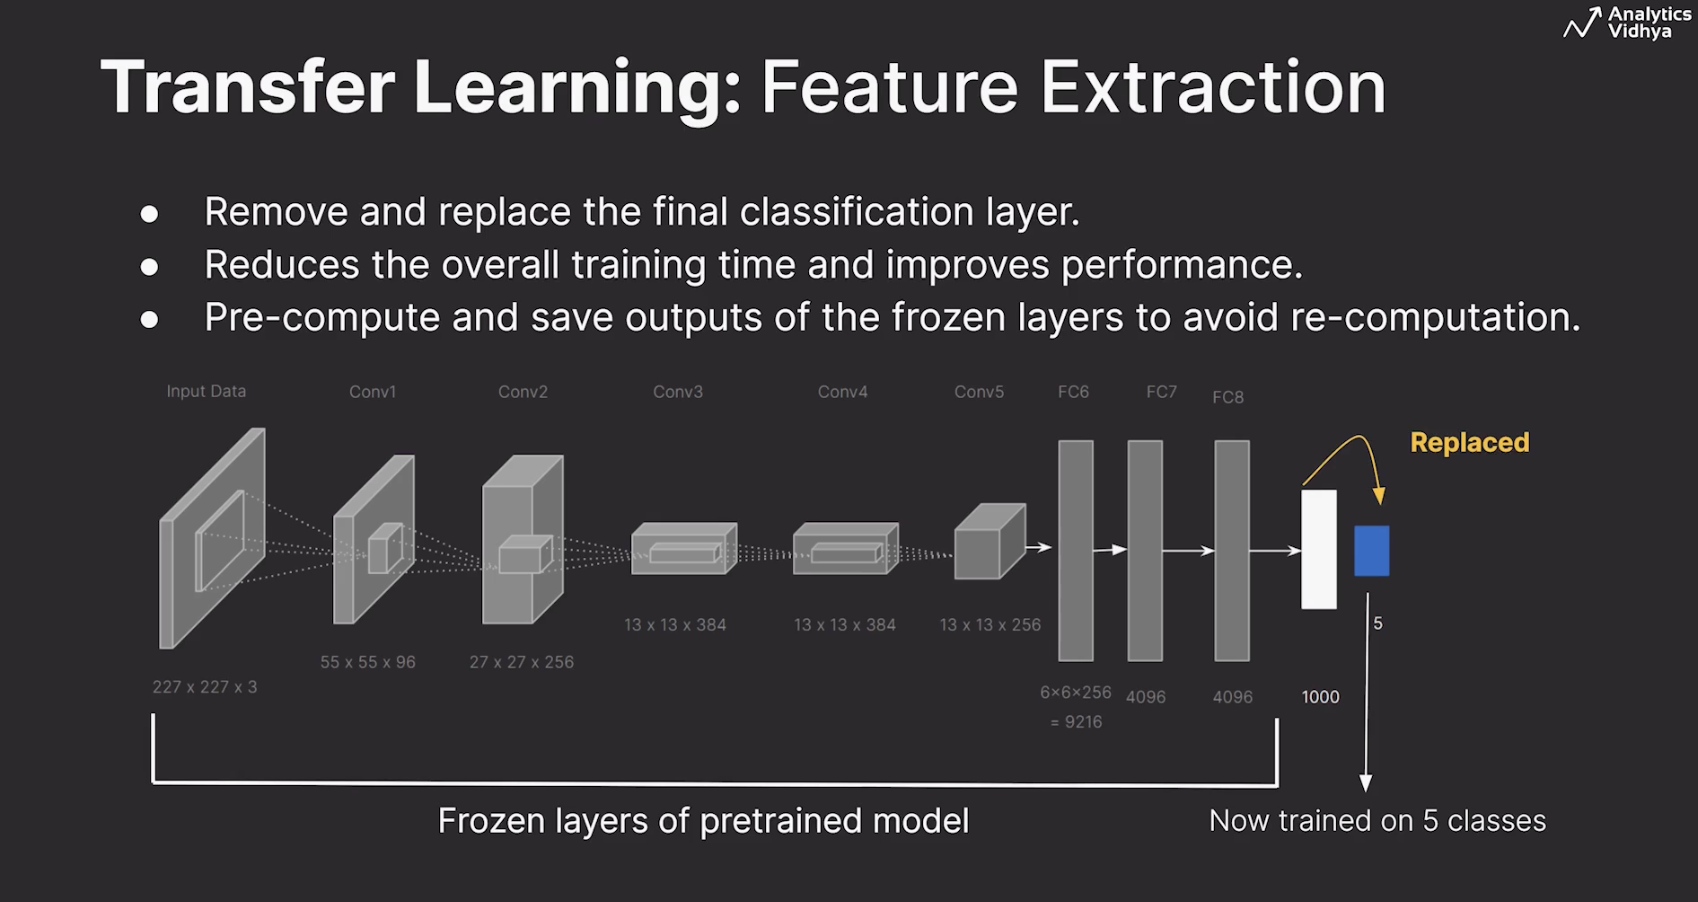

TL : FINE TUNING , SOME PRE TRAINED LAYERS ARE UNFROZEN AND RETRAINED ON THE NEW DATA.

SOME HIGHRER COMPUTATIONAL COST COMPARED TO FEATURE EXTRACTION


(SO ALMOST WHOLE MODEL IS RETRAINED)



In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets , transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)  # batch_size and shuffle are customizable
test_loader = DataLoader(test_data, batch_size=32, shuffle=False) # batch_size is customizable

In [34]:
from torchvision import transforms

# Define the transformations
transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(           # Normalize image channels
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Now use this 'transforms' object in your ImageFolder constructor:
train_data = datasets.ImageFolder(root=train_data_path, transform=transforms)
test_data = datasets.ImageFolder(root=test_data_path, transform=transforms)

In [35]:
from zipfile import ZipFile

# Specify the path to your zip file
zip_file_path = '/content/Archive.zip'

# Specify the directory where you want to extract the contents
extract_to_path = '/content/'

# Open the zip file
with ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all contents to the specified directory
    zip_ref.extractall(extract_to_path)

print(f"Extracted files to {extract_to_path}")


Extracted files to /content/


In [36]:
train_data_path = r'/content/Human Action Recognition/test'
test_data_path = r'/content/Human Action Recognition/test'


In [38]:

#FINE-TUNING
# Load the pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Freeze all the feature extractor layers and the earlier classifier layers
for param in vgg16.parameters():
    param.requires_grad = False

# Modify the classifier part of the model to match the number of classes (5 classes)
vgg16.classifier[6] = nn.Linear(4096, 5)

# Move the model to the device
model = vgg16.to(device)

# Define the loss function and the optimizer (only train the last classification layer)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier[6].parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


IMAGE AUGMENTATION IN VGG16


-> WHAT IF ARE DATA IS TOO SMALL TO TRAIN A FINE TUNER
->ARTIFICALLY EXPAND THE SIZE AND DIVERSITY OF TRAINIG DATASET
-> HELPS PREVENT OVERFITTING BY INTRODUCING VARIATIONS.
->APPLIED OON THE TRAINING SET ONLY

In [ ]:

import matplotlib.pyplot as plt

# Initialize the lists to store train and test loss for each epoch
train_losses = []
test_losses = []

# Train the model
num_epochs = 20
best_loss = torch.inf
patience = 5
epochs_since_best = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # For models that return auxiliary outputs
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)  # Store the train loss for this epoch
    train_accuracy = 100. * correct / total

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

    # Evaluate on the test set
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # For models that return auxiliary outputs
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)  # Store the test loss for this epoch
    test_accuracy = 100. * correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    # Check for best accuracy and stop if not improved after five more epochs
    if test_loss < best_loss:
        best_loss = test_loss
        epochs_since_best = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the model
        print(f'Updated best model with accuracy: {test_accuracy:.2f}%')
    else:
        epochs_since_best += 1
        if epochs_since_best > patience:
            print("Stopping early: no improvement after five consecutive epochs.")
            break

Epoch [1/20], Train Loss: 0.7308, Train Accuracy: 71.90%
Test Loss: 0.2622, Test Accuracy: 92.06%
Updated best model with accuracy: 92.06%
Epoch [2/20], Train Loss: 0.2500, Train Accuracy: 90.63%
Test Loss: 0.1769, Test Accuracy: 94.76%
Updated best model with accuracy: 94.76%
Epoch [3/20], Train Loss: 0.2006, Train Accuracy: 93.49%
Test Loss: 0.1376, Test Accuracy: 96.67%
Updated best model with accuracy: 96.67%
Epoch [4/20], Train Loss: 0.1490, Train Accuracy: 95.71%
Test Loss: 0.1160, Test Accuracy: 96.83%
Updated best model with accuracy: 96.83%
Epoch [5/20], Train Loss: 0.1449, Train Accuracy: 94.60%
Test Loss: 0.0935, Test Accuracy: 97.94%
Updated best model with accuracy: 97.94%
Epoch [6/20], Train Loss: 0.1205, Train Accuracy: 96.35%
